In [98]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

fig_dir='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/Saildrone/'

icefile='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/Ice Present.xlsx'

data_dir = 'F:/data/cruise_data/saildrone/2019_arctic/post_mission/'

adir_sbe='F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-'

data_dir_sbe_combined = 'F:/data/cruise_data/saildrone/2019_arctic/post_mission_combined/'

In [2]:
# SBE56 info
vattrs = {'long_name': 'sea surface depth','coordinates': 'time',
          'standard_name': 'sea_water_temperature', 'installed_height':'-0.295 m' ,
          'serial_number' : 'SBE05608196', 'model_number': '56', 
          'sensor_description': 'Seabird 56 Temperature Logger',
          'model_name': 'SBE 56', 'product_page':'http://www.seabird.com/sbe56-temperature-logger', 
          'nominal_sampling_schedule': '2 sec', 
          'units':'degrees_C','valid_min':-10.0,'valid_max':50.0}


astr_sbe36=['SBE05609153_2019-11-25.csv','SBE05609154_2019-11-25.csv',
         'SBE05609158_2019-11-25.csv','SBE05609150_2019-11-25.csv',
         'SBE05609151_2019-11-25.csv','SBE05609152_2019-11-25.csv',
           'SBE05609157_2019-11-25.csv']

depth36=[330,473,823,1048,1209,1436,1700]

astr_sbe37=['SBE05608196_2019-11-25.csv','SBE05604705_2019-11-25.csv',
         'SBE05605200_2019-11-25.csv','SBE05608476_2019-11-25.csv',
         'SBE05609159_2019-11-25.csv','SBE05609155_2019-11-26.csv',
         'SBE05609156_2019-11-26.csv']
depth37=[324,474,805,1035,1196,1413,1725]

adepth=[depth36,depth37]
astr = [astr_sbe36,astr_sbe37]

ds_info = xr.Dataset(data_vars={'fname':(['trajectory','z'],astr),
                                'depth':(['trajectory','z'],adepth)},
                     coords={'z':np.arange(7),'trajectory':[1036,1037]})




In [25]:
for itt in range(0,2):
    for iz  in range(7):
        if (itt==0) and (iz==3):
            continue
        fstr = str(ds_info.fname[itt,iz].data)
        avehicle=str(ds_info.trajectory[itt].data)
        filename=adir_sbe+avehicle+'/'+fstr
        print(filename)
        df = pd.read_csv(filename,header=11) #, sheet_name='data')
        #increment time by 6 seconds so that minute average ois from 0-12seconds rather than -6 to +6 seconds around zeros
        #offset = pd.to_timedelta(6, unit='s') 
        df['time']=pd.to_datetime(df['Date'] + ' ' + df['Time']) #+offset
        del df['Date']
        del df['Time']
        df.index=df['time']
        xf=df.to_xarray()
        vname='sea_water_temperature_'+str(iz).zfill(2)
        xf=xf.rename({'Temperature':vname})
        vattrs['installed_height']=str(-1*ds_info.depth[itt,iz].data/1000.)+' m'
        vattrs['serial_number']=fstr[:11]
        xf.attrs=vattrs
        if iz==0:
            ds_sbe=xr.Dataset({'sea_water_temperature_00':xf[vname]})
            ds_sbe[vname].attrs=vattrs
        else:
            ds_sbe=ds_sbe.assign(vname=xf[vname])
            ds_sbe=ds_sbe.rename({'vname':vname})
            ds_sbe[vname].attrs=vattrs
    fout=adir_sbe+'combined'+avehicle+'.nc'
    ds_sbe.to_netcdf(fout)

F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609153_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609154_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609158_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609151_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609152_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609157_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05608196_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05604705_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05605200_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05608476_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05609159_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05609155_2019-11-26.csv
F:/d

In [41]:
itt=0
avehicle=str(ds_info.trajectory[itt].data)
filename=adir_sbe+'combined'+avehicle+'.nc'
filename_out=adir_sbe+'combined_1minave'+avehicle+'.nc'
xf=xr.open_dataset(filename)
iz=0
print(itt,iz)
vname='sea_water_temperature_'+str(iz).zfill(2)
vnamemn='sea_water_temperature_'+str(iz).zfill(2)+'_mean'
vnamestd='sea_water_temperature_'+str(iz).zfill(2)+'_std'
offset = pd.to_timedelta(6, unit='s') 
xftem=xf[vname]
pt = pd.to_datetime(xftem.time.data)+offset  #add 6 seconds
psec=pt.second
tem=xftem[(psec <=12)]  #data average should be only use sec 54 to sec 06 of each minute 
tem['time']=tem['time']+offset #resample goes from :00 to :59 so shift +6sec
xf_avg1 = tem.resample(time='1min').mean(keep_attrs=True)
xf_std1 = tem.resample(time='1min').std(ddof=1,keep_attrs=True)
sattrs=xf[vname].attrs
sattrs['nominal_sampling_schedule']='1 minute averages from :54 to :06 seconds'
sattrs['long_name']='sea surface depth 1-min mean'
xf_avg1.attrs=sattrs
sattrs['long_name']='sea surface depth 1-min standard dev'
xf_std1.attrs=sattrs
if iz==0:
    ds_sbe=xr.Dataset({'vname':xf_avg1})
    ds_sbe=ds_sbe.rename({'vname':vnamemn})
    ds_sbe=ds_sbe.assign(vname=xf_std1)
    ds_sbe=ds_sbe.rename({'vname':vnamestd})
else:
    ds_sbe=ds_sbe.assign(vname=xf_avg1)
    ds_sbe=ds_sbe.rename({'vname':vnamemn})
    ds_sbe=ds_sbe.assign(vname=xf_std1)
    ds_sbe=ds_sbe.rename({'vname':vnamestd})
#ds_sbe.drop(vname)


0 0


In [45]:
#ds_sbe2=ds_sbe.where(np.isfinite(ds_sbe.sea_water_temperature_00_mean),drop=True)
#ds_sbe2
#ds_sbe.sea_water_temperature_00_mean[1000:1020]
#ds_sbe.time[1000:1100]
#xf_avg1[1000:1020]

<xarray.Dataset>
Dimensions:                        (time: 310582)
Coordinates:
  * time                           (time) datetime64[ns] 2019-04-18 ... 2019-11-19T16:21:00
Data variables:
    sea_water_temperature_00_mean  (time) float64 21.24 21.24 ... 20.19 20.37
    sea_water_temperature_00_std   (time) float64 7.071e-05 0.0002 ... 0.03055

In [48]:
#make 1min average data

for itt in range(2):
    avehicle=str(ds_info.trajectory[itt].data)
    filename=adir_sbe+'combined'+avehicle+'.nc'
    filename_out=adir_sbe+'combined_1minave'+avehicle+'.nc'
    xf=xr.open_dataset(filename)
    for iz  in range(7):
        if (itt==0) and (iz==3):
            continue
        print(itt,iz)
        vname='sea_water_temperature_'+str(iz).zfill(2)
        vnamemn='sea_water_temperature_'+str(iz).zfill(2)+'_mean'
        vnamestd='sea_water_temperature_'+str(iz).zfill(2)+'_std'
        offset = pd.to_timedelta(6, unit='s') 
        xftem=xf[vname]
        pt = pd.to_datetime(xftem.time.data)+offset  #add 6 seconds
        psec=pt.second
        tem=xftem[(psec <=12)]  #data average should be only use sec 54 to sec 06 of each minute 
        tem['time']=tem['time']+offset #resample goes from :00 to :59 so shift +6sec
        xf_avg1 = tem.resample(time='1min').mean(keep_attrs=True)
        xf_std1 = tem.resample(time='1min').std(ddof=1,keep_attrs=True)
        sattrs=xf[vname].attrs
        sattrs['nominal_sampling_schedule']='1 minute averages from :54 to :06 seconds'
        sattrs['long_name']='sea surface depth 1-min mean'
        xf_avg1.attrs=sattrs
        sattrs['long_name']='sea surface depth 1-min standard dev'
        if iz==0:
            ds_sbe=xr.Dataset({'vname':xf_avg1})
            ds_sbe=ds_sbe.rename({'vname':vnamemn})
            ds_sbe=ds_sbe.assign(vname=xf_std1)
            ds_sbe=ds_sbe.rename({'vname':vnamestd})
        else:
            ds_sbe=ds_sbe.assign(vname=xf_avg1)
            ds_sbe=ds_sbe.rename({'vname':vnamemn})
            ds_sbe=ds_sbe.assign(vname=xf_std1)
            ds_sbe=ds_sbe.rename({'vname':vnamestd})
        #ds_sbe = ds_sbe.drop(vname)
    ds_sbe2=ds_sbe.where(np.isfinite(ds_sbe.sea_water_temperature_00_mean),drop=True)
    fout=adir_sbe+'combined'+avehicle+'.nc'
    ds_sbe2.to_netcdf(filename_out)

0 0
0 1
0 2
0 4
0 5
0 6
1 0
1 1


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


1 2
1 3
1 4
1 5
1 6


In [96]:
for iusv in range(2):
    if iusv==0:
        fname='saildrone-gen_5-arctic_misst_2019-sd1036-20190514T230000-20191011T183000-1_minutes-v1.1575336154680.nc'
        fname2='sd-combined_1minave1036.nc'
    if iusv==1:
        fname='saildrone-gen_5-arctic_misst_2019-sd1037-20190514T230000-20191011T183000-1_minutes-v1.1575487464625.nc'
        fname2='sd-combined_1minave1037.nc'
    ds = xr.open_dataset(data_dir+fname)
    ds.close()
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds['time']=ds.time[0,:]
    ds = ds.swap_dims({'obs':'time'})
    #calculate some variables
    ds['wspd_MEAN']=np.sqrt(ds.UWND_MEAN**2+ds.VWND_MEAN**2)
    ds['wdir_MEAN']=np.arctan2(ds.VWND_MEAN,ds.UWND_MEAN)*180./np.pi
    ds_sbe=xr.open_dataset(adir_sbe[:-3]+fname2)
    ds_sbe.close()
    ds_tem=ds_sbe.interp(time=ds.time,method='nearest')
    ds = ds.isel(trajectory=0)
    for var in ds_tem:
        ds[var]=ds_sbe[var]
    fname_out=fname[:-3]+'-withSBE.nc'
    ds.to_netcdf((data_dir_sbe_combined+fname_out)

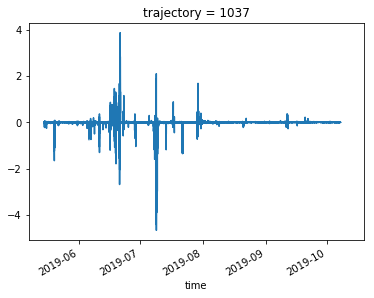

In [94]:
(ds.TEMP_CTD_RBR_MEAN-ds.sea_water_temperature_00_mean).plot()


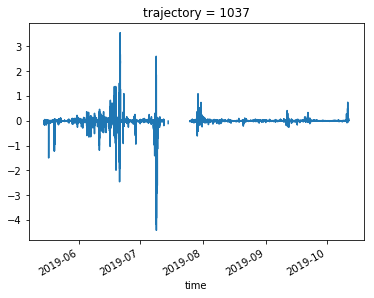

In [95]:
(ds.TEMP_SBE37_MEAN-ds.sea_water_temperature_00_mean).plot()


In [99]:
ds = xr.open_mfdataset(data_dir_sbe_combined+'*.nc',combine='nested',concat_dim='trajectory').load()
ds

<xarray.Dataset>
Dimensions:                         (time: 215731, trajectory: 2)
Coordinates:
  * time                            (time) datetime64[ns] 2019-05-14T23:00:00 ... 2019-10-11T18:30:00
    lat                             (trajectory, time) float64 53.85 ... 53.84
    lon                             (trajectory, time) float64 -166.6 ... -166.6
  * trajectory                      (trajectory) object '1036' '1037'
Data variables:
    SOG                             (trajectory, time) float64 1.41 ... 0.005
    SOG_FILTERED_MEAN               (trajectory, time) float64 1.194 ... 0.028
    SOG_FILTERED_STDDEV             (trajectory, time) float64 0.096 ... 0.02
    SOG_FILTERED_MAX                (trajectory, time) float64 1.48 ... 0.095
    SOG_FILTERED_MIN                (trajectory, time) float64 1.041 ... 0.002
    COG                             (trajectory, time) float64 324.0 ... 93.4
    COG_FILTERED_MEAN               (trajectory, time) float64 324.6 ... 83.2
    COG_

In [100]:
#make diruanl plot
ds2=ds#.isel(trajectory=0)
xlon=ds2.lon
tdif=ds2.TEMP_CTD_RBR_MEAN-ds2.TEMP_SBE37_MEAN
time_offset_to_lmt=(xlon/360.)*24.*60
ds2['tlmt']=ds2.lon
for i in range(2):
    ds2['tlmt'][i,:]= ds2.time.data+time_offset_to_lmt[i,:]*np.timedelta64(1,'m')# dt.timedelta(seconds=1)

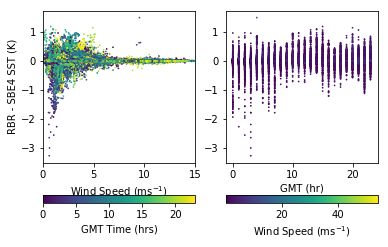

In [101]:
fig,(ax1,ax2) =plt.subplots(1,2)
for i in range(2):
    cs=ax1.scatter(ds2.wspd_MEAN[i,:],tdif[i,:],c=ds2.time.dt.hour,s=.5)
ax1.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='RBR - SBE4 SST (K)')
ax1.set_xlim(0,15)
cbar = fig.colorbar(cs,orientation='horizontal',ax=ax1)
cbar.set_label('GMT Time (hrs)')
for i in range(2):
    cs2=ax2.scatter(ds2.time.dt.hour,tdif[i,:],c=ds2.wspd_MEAN[i,:],s=.5)
ax2.set(xlabel='GMT (hr)')
cbar = fig.colorbar(cs2,orientation='horizontal',ax=ax2)
cbar.set_label('Wind Speed (ms$^{-1}$)')
fig.savefig(fig_dir+'figs/temp_buld_dw_data.png')

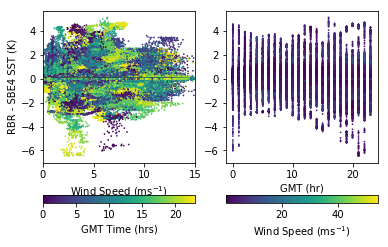

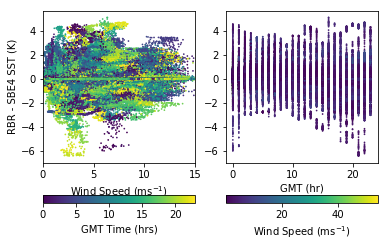

In [105]:
tdif=ds2.TEMP_CTD_RBR_MEAN-ds2.sea_water_temperature_02_mean
fig,(ax1,ax2) =plt.subplots(1,2)
for i in range(2):
    cs=ax1.scatter(ds2.wspd_MEAN[i,:],tdif[i,:],c=ds2.time.dt.hour,s=.5)
ax1.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='RBR - SBE4 SST (K)')
ax1.set_xlim(0,15)
cbar = fig.colorbar(cs,orientation='horizontal',ax=ax1)
cbar.set_label('GMT Time (hrs)')
for i in range(2):
    cs2=ax2.scatter(ds2.time.dt.hour,tdif[i,:],c=ds2.wspd_MEAN[i,:],s=.5)
ax2.set(xlabel='GMT (hr)')
cbar = fig.colorbar(cs2,orientation='horizontal',ax=ax2)
cbar.set_label('Wind Speed (ms$^{-1}$)')
fig.savefig(fig_dir+'figs/temp_rbr-sbe-buld_dw_data.png')


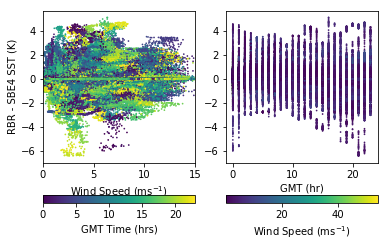

In [106]:

tdif=ds2.TEMP_SBE37_MEAN-ds2.sea_water_temperature_02_mean
fig,(ax1,ax2) =plt.subplots(1,2)
for i in range(2):
    cs=ax1.scatter(ds2.wspd_MEAN[i,:],tdif[i,:],c=ds2.time.dt.hour,s=.5)
ax1.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='RBR - SBE4 SST (K)')
ax1.set_xlim(0,15)
cbar = fig.colorbar(cs,orientation='horizontal',ax=ax1)
cbar.set_label('GMT Time (hrs)')
for i in range(2):
    cs2=ax2.scatter(ds2.time.dt.hour,tdif[i,:],c=ds2.wspd_MEAN[i,:],s=.5)
ax2.set(xlabel='GMT (hr)')
cbar = fig.colorbar(cs2,orientation='horizontal',ax=ax2)
cbar.set_label('Wind Speed (ms$^{-1}$)')
fig.savefig(fig_dir+'figs/temp_sbe-sbe-buld_dw_data.png')

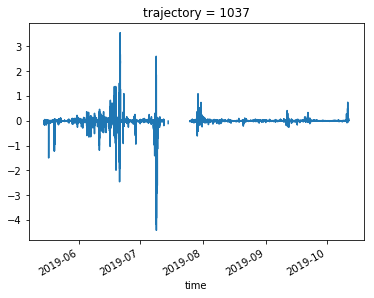

In [112]:
tdif=ds.TEMP_SBE37_MEAN-ds.sea_water_temperature_00_mean
tdif[i,:].plot()

In [122]:
tdif=ds.TEMP_SBE37_MEAN-ds.sea_water_temperature_01_mean
print(tdif.mean('time').data,tdif.std('time').data)
tdif=ds.TEMP_CTD_RBR_MEAN-ds.sea_water_temperature_01_mean
print(tdif.mean('time').data,tdif.std('time').data)
tdif=ds.TEMP_O2_RBR_MEAN-ds.sea_water_temperature_01_mean
print(tdif.mean('time').data,tdif.std('time').data)

[-0.00608404 -0.00498099] [0.96251881 0.08145148]
[-0.00850286 -0.00381481] [0.96163557 0.10478591]
[-0.00122958  0.01431352] [0.96055359 0.13102051]


In [123]:
tdif=ds.TEMP_SBE37_MEAN-ds.sea_water_temperature_00_mean
print(tdif.mean('time').data,tdif.std('time').data)
tdif=ds.TEMP_CTD_RBR_MEAN-ds.sea_water_temperature_00_mean
print(tdif.mean('time').data,tdif.std('time').data)
tdif=ds.TEMP_O2_RBR_MEAN-ds.sea_water_temperature_00_mean
print(tdif.mean('time').data,tdif.std('time').data)

[-0.01380081 -0.01452271] [0.98293866 0.1653436 ]
[-0.01633141 -0.01360196] [0.98204868 0.1905742 ]
[-0.00905812  0.00449801] [0.98086711 0.20057166]


In [124]:
tdif=ds.TEMP_SBE37_MEAN-ds.sea_water_temperature_02_mean
print(tdif.mean('time').data,tdif.std('time').data)
tdif=ds.TEMP_CTD_RBR_MEAN-ds.sea_water_temperature_02_mean
print(tdif.mean('time').data,tdif.std('time').data)
tdif=ds.TEMP_O2_RBR_MEAN-ds.sea_water_temperature_02_mean
print(tdif.mean('time').data,tdif.std('time').data)

[0.01273592 0.00796006] [0.94156968 0.12335199]
[0.01058636 0.00900744] [0.93983742 0.10762502]
[0.01785964 0.02710741] [0.93905946 0.13512464]


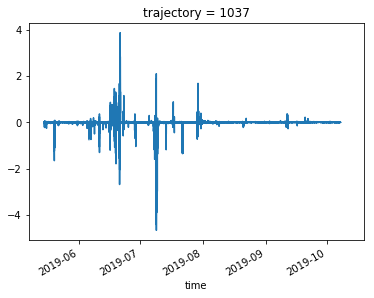

In [128]:
(ds.TEMP_CTD_RBR_MEAN-ds.sea_water_temperature_00_mean)[1,:].plot()
        